## Explore the bias data in the FACTors dataset

The creators of the FACTors dataset, analysed all content with politicalBiasBERT. From this analyses it becomes clear that politicalBiasBERT, does not work that well on the fact-check articles, since authors that seem to be biased often score high on left and right.

First 12 articles that contain multiple claims are removed from the FACTors dataset.

In [1]:
import pandas as pd

# Load the data
factors_df = pd.read_csv("Data/FACTors.csv")

# Identify article_ids that occur only once
article_counts = factors_df['article_id'].value_counts()
duplicate_article_ids = article_counts[article_counts > 1]
unique_article_ids = article_counts[article_counts == 1].index

# Filter the DataFrame to keep only unique article_ids
clean_factors_df = factors_df[factors_df['article_id'].isin(unique_article_ids)]

# Confirm removal
print(f"Original rows: {len(factors_df)}")
print(f"Articles with multiple claims: {len(duplicate_article_ids)}")
print(f"Rows after removing duplicates: {len(clean_factors_df)}")

Original rows: 118112
Articles with multiple claims: 12
Rows after removing duplicates: 117981


Next the data is joined with the content_bias_scores.csv and the bias numbers for Left, Center and Right are added to separate variables.

In [60]:
import ast

# Join the dataframes clean_factors_df and bias_df
bias_df = pd.read_csv("Data/content_bias_scores.csv")
joined_df = pd.merge(bias_df[["article_id","bias_scores"]], clean_factors_df, on='article_id', how='inner')

# Convert the string of bias scores to a list 
joined_df["bias_scores"] = joined_df["bias_scores"].apply(ast.literal_eval)

#Extract the bias scores to separate columns
joined_df["left_bias"]=joined_df["bias_scores"].apply(lambda x: x[0])
joined_df["not_biased"]=joined_df["bias_scores"].apply(lambda x: x[1])
joined_df["right_bias"]=joined_df["bias_scores"].apply(lambda x: x[2])
joined_df.drop(columns=["bias_scores"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117930 entries, 0 to 117929
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   article_id         117930 non-null  int64  
 1   row_id             117930 non-null  int64  
 2   claim_id           117930 non-null  int64  
 3   claim              117930 non-null  object 
 4   date_published     117930 non-null  object 
 5   author             117930 non-null  object 
 6   organisation       117930 non-null  object 
 7   original_verdict   117930 non-null  object 
 8   title              117930 non-null  object 
 9   url                117930 non-null  object 
 10  normalised_rating  117930 non-null  object 
 11  left_bias          117930 non-null  float64
 12  not_biased         117930 non-null  float64
 13  right_bias         117930 non-null  float64
dtypes: float64(3), int64(3), object(8)
memory usage: 12.6+ MB
None


Check the average Bias and number of article written for each author.

In [62]:
author_bias_stats = joined_df.groupby(['author','organisation']).agg(
    left_bias_mean=('left_bias', 'mean'),
    not_biased_mean=('not_biased', 'mean'),
    right_bias_mean=('right_bias', 'mean'),
    article_count=('article_id', 'count')
).reset_index()

print(author_bias_stats.head())

                   author    organisation  left_bias_mean  not_biased_mean  \
0              'Juwon Ojo          Dubawa        0.008268         0.981461   
1  A. Kwabena Brakopowers          Dubawa        0.322538         0.439818   
2             A. Momar Lo    Africa Check        0.006335         0.965391   
3           Aaishah Janif  AFP Fact Check        0.193039         0.606510   
4          Aaron Bartilad      PressOnePH        0.111752         0.074598   

   right_bias_mean  article_count  
0         0.010271              1  
1         0.237644              1  
2         0.028274              1  
3         0.200450             12  
4         0.813650              5  


Filter on authors, who have publised at least 100 articles

In [80]:
author_bias_stats_filtered = author_bias_stats[author_bias_stats['article_count'] >= 100]
author_bias_stats_filtered.head()

,author,organisation,left_bias_mean,not_biased_mean,right_bias_mean,article_count
9,Aayushi Rana,DFRAC_ORG,0.113106,0.417092,0.469802,163
10,Abbas Panjwani,Full Fact,0.272904,0.557823,0.169273,411
27,Abhilash Mallick,WebQoof,0.278556,0.481163,0.240281,373
31,Abhishek Anand,WebQoof,0.270673,0.328863,0.400464,669
35,Abhishek Mandadi,FACTLY,0.258110,0.441887,0.300003,293


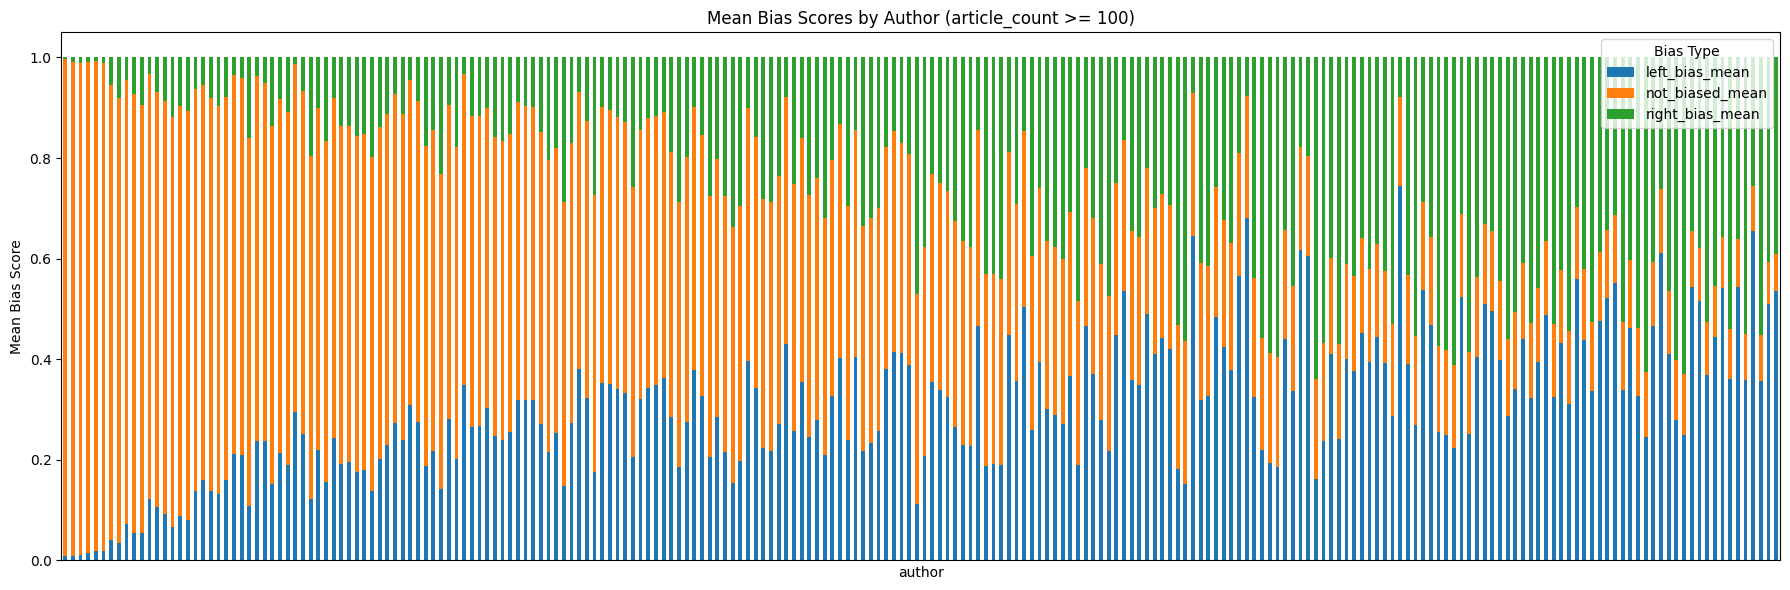

In [84]:
import matplotlib.pyplot as plt

# Sort by not_biased_mean in descending order (change ascending=True if you want lowest first)
author_bias_stats_filtered_sorted = author_bias_stats_filtered.sort_values(by='not_biased_mean', ascending=False)

# Plot left_bias_mean, not_biased_mean, and right_bias_mean for each author (filtered & sorted)
author_bias_stats_filtered_sorted.plot(
    x='author',
    y=['left_bias_mean', 'not_biased_mean', 'right_bias_mean'],
    kind='bar',
    figsize=(18, 6),
    stacked=True
)
plt.ylabel('Mean Bias Score')
plt.title('Mean Bias Scores by Author (article_count >= 100)')
plt.xticks([], [])  # Hide x-axis labels for readability
plt.legend(title='Bias Type')
plt.tight_layout()
plt.show()

More to the left are authors that are generally not biased according to the analysis with politicalBiasBERT, however there are not that many authors who linger much more to the left then right. Many authors seem to be biased to the left and right. 

## Explore Bias with the Media Bias Factcheck data

Extract the root domain, to merge it with the mediabiasfactcheck data

In [ ]:
import tldextract

# Apply tldextract to get the root domain
clean_factors_df.loc[:, "root_domain"] = clean_factors_df["url"].apply(
    lambda x: f"{tldextract.extract(x).domain}.{tldextract.extract(x).suffix}"
)
organisations_url_df=clean_factors_df.groupby("root_domain").size().reset_index(name="count").sort_values(by="count", ascending=False)
print(organisations_url_df)


           root_domain  count
26      politifact.com  20977
28          snopes.com  19792
2              afp.com  11799
3      africacheck.org   6316
24       newsmobile.in   6223
32        thequint.com   5985
15           factly.in   4783
18        fullfact.org   4533
23        newsmeter.in   4161
12       factcheck.org   4154
19       indiatoday.in   2928
36       verafiles.org   2879
6          boomlive.in   2780
8            dfrac.org   2463
33          thip.media   1834
37     vishvasnews.com   1786
7    checkyourfact.com   1727
22    mythdetector.com   1686
10          dubawa.org   1662
0           aap.com.au   1474
16        feedback.org   1216
11        factcheck.ge    923
29     thedispatch.com    902
31       thejournal.ie    828
9          digiteye.in    743
38  wisconsinwatch.org    537
20     leadstories.com    497
4         annielab.org    323
17       firstcheck.in    298
13     factcheckni.org    258
27         pressone.ph    258
25            pa.media    249
34      ts

In [ ]:
# Load the MBFC data
mbfc_df=pd.read_csv("Data/mbfc_raw.csv")
mbfc_df

,source,country,bias,factual_reporting,press_freedom,media_type,popularity,mbfc_credibility_rating
0,9news.com,usa,least biased,high,mostly free,tv station,high traffic,high credibility
1,nbc11news.com,usa,least biased,high,mostly free,tv station,medium traffic,high credibility
2,12news.com,usa,least biased,high,mostly free,tv station,medium traffic,high credibility
3,wibw.com,usa,least biased,high,mostly free,tv station,medium traffic,high credibility
4,wifr.com,usa,least biased,high,mostly free,tv station,medium traffic,high credibility
...,...,...,...,...,...,...,...,...
4492,skeptiko.com,usa,NaN,very low,usa 45/180,NaN,NaN,NaN
4493,clashdaily.com,usa,extreme right,low,mostly free,website,medium traffic,low credibility
4494,globemagazine.com,usa,unrated,very low,mostly free,magazine,minimal traffic,low credibility
4495,nextobserver.com,NaN,NaN,high,NaN,NaN,NaN,NaN


Merge the two data sets.

Continue with the first 5 high traffic sources

In [ ]:
# Merge mbfc_df with organisations_url_df on the root_domain/source columns
merged_df = mbfc_df.merge(organisations_url_df,left_on="source", right_on="root_domain", how="inner")
merged_df.sort_values(by="count", ascending=False)